<a href="https://colab.research.google.com/github/Blackman9t/Advanced-Data-Science/blob/master/dimensionality_reduction_pyspark.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Dimensionality Reduction (DR):

It sometimes becomes hard to choose the correct dimensions for plotting. So we will learn how an algorithm can do this for us. DR is more than just getting rid of columns in a dataset. it's more on transforming everything to a new dataset but preserving some key properties.

### Principal Component Analysis (PCA):

The idea is that we take an n-dimensional(n number of columns) dataset where every row can be seen as a point in an n-dimensional euclidean vector space and each column as one coordinate in that space.<br>Mathematicians call such a space $R^n$, because the values on each axes are real numbers and every vector representing a point in that space needs $n$-elements.<br>

So PCA transforms a dataset by specifying the number of desired dimensions in a way that the new dataset represents the very same points with vectors of lower dimensions $k$<br>This process is also called projections.<br>
PCA ensures that if two points in the original dataset are far apart from each other, they are also far awy in the reduced dataset with an equal ratio of distance. This is same for close points too.

After this projection, the new dimensions returned are explaining the majority of variations in the dataset. in otherwords, the so-called Principal Components are chosen such that the information contents of each additional dimension is decreasing.

This is a way of getting rid of highly-correlated dimensions in the original dataset because their additional information content is low. the principal component dimensions are all orthogonal to each other and made up of dimensions that are not highly correlated to each other.

So this means that we can spot clusters, potential separations, planes and outliers also in the lower dimensional dataset, but with the added functionality that the lower dataset can be plotted, especially if we reduce the dimension to 3 (x,y,z).

When applying PCA, we are losing some information, but PCA is very intelligent in deciding what parts of the info is less relevant. So that the pain of removing information is minimized.

Ofcourse the lower we choose $k$, the higher the losses.

Loss can be easily estimated by comparing the original dataset with the one that PCA was applied, and then the inverse function of PCA is applied again to reconstruct the original dataset.

The function used for comparing those two datasets is SSE or Sum-0f-Squared-Errors. this way, we get an idea of the percentage of info we are losing in the PCA dataset.

This means the amount of info lost can be easily quantified and kept track of as we apply PCA to our datasets.



## Exercise 3.2
Welcome to the last exercise of this course. This is also the most advanced one because it somehow glues everything together you've learned.

These are the steps you will do:

Load a data frame from cloudant/ApacheCouchDB.<br>
Perform feature transformation by calculating minimal and maximal values of different properties on time windows (we'll explain what a time windows is later in here).<br>
Reduce these now twelve dimensions to three using the PCA (Principal Component Analysis) algorithm of SparkML (Spark Machine Learning) => We'll actually make use of SparkML a lot more in the next course.<br>
Plot the dimensionality reduced data set.

First, let's install Spark related dependencies.

In [1]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q http://apache.osuosl.org/spark/spark-2.4.5/spark-2.4.5-bin-hadoop2.7.tgz
!tar xf spark-2.4.5-bin-hadoop2.7.tgz

!pip install -q findspark
!pip install pyspark
# Set up required environment variables

import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-2.4.5-bin-hadoop2.7"

     |████████████████████████████████| 217.8MB 63kB/s 
     |████████████████████████████████| 204kB 49.3MB/s 
  Created wheel for pyspark: filename=pyspark-2.4.5-py2.py3-none-any.whl size=218257927 sha256=618ed0dcc0ea08cbd830eb8300cdc00b81fa2ca356157340a2cd2cae8d48fb60
  Stored in directory: /root/.cache/pip/wheels/bf/db/04/61d66a5939364e756eb1c1be4ec5bdce6e04047fc7929a3c3c
Successfully built pyspark


Next, let's initialise a Spark Context(sc) if one does not already exist.

In [2]:
from pyspark import SparkConf, SparkContext

try:
    conf = SparkConf().setMaster("local").setAppName("My_App")
    sc = SparkContext(conf = conf)
    print('SparkContext Initialised Successfully!')
except Exception as e:
    print(e)

SparkContext Initialised Successfully!


In [3]:
# Let's see the Spark Context
sc

<SparkContext master=local appName=My_App>

Next, let's create our Spark session wherein we will perform parallelized activities through the Spark context.

In [4]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('My App').getOrCreate()
spark

Since JSON data can be semi-structured and contain additional metadata, it is possible that you might face issues with the DataFrame layout.<br>
Please read the documentation of 'SparkSession.read()' to learn more about the possibilities to adjust the data loading.<br>
PySpark documentation: http://spark.apache.org/docs/2.0.2/api/python/pyspark.sql.html#pyspark.sql.DataFrameReader.json

Now let's import the dataset

In [5]:
!wget https://github.com/IBM/coursera/blob/master/coursera_ds/washing.parquet?raw=true
!mv washing.parquet?raw=true washing.parquet

--2020-02-17 16:47:55--  https://github.com/IBM/coursera/blob/master/coursera_ds/washing.parquet?raw=true
Resolving github.com (github.com)... 140.82.118.4
Connecting to github.com (github.com)|140.82.118.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/IBM/coursera/raw/master/coursera_ds/washing.parquet [following]
--2020-02-17 16:47:55--  https://github.com/IBM/coursera/raw/master/coursera_ds/washing.parquet
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/IBM/coursera/master/coursera_ds/washing.parquet [following]
--2020-02-17 16:47:56--  https://raw.githubusercontent.com/IBM/coursera/master/coursera_ds/washing.parquet
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP re

In [6]:
df = spark.read.parquet("washing.parquet")
df.createOrReplaceTempView('washing')
df.show()

+--------------------+--------------------+-----+--------+----------+---------+--------+-----+-----------+-------------+-------+
|                 _id|                _rev|count|flowrate|fluidlevel|frequency|hardness|speed|temperature|           ts|voltage|
+--------------------+--------------------+-----+--------+----------+---------+--------+-----+-----------+-------------+-------+
|0d86485d0f88d1f9d...|1-57940679fb8a713...|    4|      11|acceptable|     null|      77| null|        100|1547808723923|   null|
|0d86485d0f88d1f9d...|1-15ff3a0b304d789...|    2|    null|      null|     null|    null| 1046|       null|1547808729917|   null|
|0d86485d0f88d1f9d...|1-97c2742b68c7b07...|    4|    null|      null|       71|    null| null|       null|1547808731918|    236|
|0d86485d0f88d1f9d...|1-eefb903dbe45746...|   19|      11|acceptable|     null|      75| null|         86|1547808738999|   null|
|0d86485d0f88d1f9d...|1-5f68b4c72813c25...|    7|    null|      null|       75|    null| null|   

In [7]:
# Let's see the number of rows in washing
df.count()

2058

### Feature Transformation

This is the feature transformation part of this exercise. <br>Since our table is mixing schemas from different sensor data sources we are creating new features. In other word we use existing columns to calculate new ones. <br>We only use min and max for now, but using more advanced aggregations as we've learned in week three may improve the results. We are calculating those aggregations over a sliding window "w". <br>This window is defined in the SQL statement and basically reads the table by a one by one stride in direction of increasing timestamp. <br>Whenever a row leaves the window a new one is included. Therefore this window is called sliding window (in contrast to tubling, time or count windows). <br>Generally speaking, a window defines a finite set of elements on an unbounded stream. This set can be based on time (as in our previous examples), element counts, a combination of counts and time, or some custom logic to assign elements to windows<br>More on this can be found here: https://flink.apache.org/news/2015/12/04/Introducing-windows.html

In [0]:
result = spark.sql("""
SELECT * from (
    SELECT
    min(temperature) over w as min_temperature,
    max(temperature) over w as max_temperature, 
    min(voltage) over w as min_voltage,
    max(voltage) over w as max_voltage,
    min(flowrate) over w as min_flowrate,
    max(flowrate) over w as max_flowrate,
    min(frequency) over w as min_frequency,
    max(frequency) over w as max_frequency,
    min(hardness) over w as min_hardness,
    max(hardness) over w as max_hardness,
    min(speed) over w as min_speed,
    max(speed) over w as max_speed
    FROM washing 
    WINDOW w AS (ORDER BY ts ROWS BETWEEN CURRENT ROW AND 10 FOLLOWING) 
)
WHERE min_temperature is not null 
AND max_temperature is not null
AND min_voltage is not null
AND max_voltage is not null
AND min_flowrate is not null
AND max_flowrate is not null
AND min_frequency is not null
AND max_frequency is not null
AND min_hardness is not null
AND min_speed is not null
AND max_speed is not null   
""")

In [9]:
print(result.count(),len(result.columns))

2051 12


Since this table contains null values also our window might contain them. In case for a certain feature all values in that window are null we obtain also null. As we can see here (in my dataset) this is the case for 9 rows.

In [10]:
df.count() - result.count()

7

Now we import some classes from SparkML. PCA for the actual algorithm. Vectors for the data structure expected by PCA and VectorAssembler to transform data into these vector structures.

In [0]:
from pyspark.ml.feature import PCA
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler

Let's define a vector transformation helper class which takes all our input features (result.columns) and created one additional column called "features" which contains all our input features as one single column wrapped in "DenseVector" objects

In [0]:
assembler = VectorAssembler(inputCols=result.columns, outputCol="features")

Now we actually transform the data, note that this is highly optimized code and runs really fast in contrast if we had implemented it.

In [0]:
features = assembler.transform(result)

Let's have a look at how this new additional column "features" looks like:

In [14]:
features.show()

+---------------+---------------+-----------+-----------+------------+------------+-------------+-------------+------------+------------+---------+---------+--------------------+
|min_temperature|max_temperature|min_voltage|max_voltage|min_flowrate|max_flowrate|min_frequency|max_frequency|min_hardness|max_hardness|min_speed|max_speed|            features|
+---------------+---------------+-----------+-----------+------------+------------+-------------+-------------+------------+------------+---------+---------+--------------------+
|             81|            100|        221|        223|          11|          11|           68|           76|          71|          78|     1033|     1033|[81.0,100.0,221.0...|
|             81|            100|        221|        223|          11|          11|           68|           76|          72|          78|     1033|     1033|[81.0,100.0,221.0...|
|             81|            100|        221|        223|          11|          11|           68|        

Let's select only the features column of the Spark data frame

In [15]:
features.select('features').show(10)

+--------------------+
|            features|
+--------------------+
|[81.0,100.0,221.0...|
|[81.0,100.0,221.0...|
|[81.0,100.0,221.0...|
|[81.0,100.0,222.0...|
|[81.0,100.0,222.0...|
|[80.0,94.0,222.0,...|
|[80.0,94.0,222.0,...|
|[80.0,94.0,222.0,...|
|[80.0,94.0,222.0,...|
|[80.0,94.0,222.0,...|
+--------------------+
only showing top 10 rows



Let's read the features Dataframe as an rdd object

In [16]:
features.rdd.map(lambda r: r.features).take(10)

[DenseVector([81.0, 100.0, 221.0, 223.0, 11.0, 11.0, 68.0, 76.0, 71.0, 78.0, 1033.0, 1033.0]),
 DenseVector([81.0, 100.0, 221.0, 223.0, 11.0, 11.0, 68.0, 76.0, 72.0, 78.0, 1033.0, 1033.0]),
 DenseVector([81.0, 100.0, 221.0, 223.0, 11.0, 11.0, 68.0, 76.0, 72.0, 80.0, 1033.0, 1033.0]),
 DenseVector([81.0, 100.0, 222.0, 223.0, 11.0, 11.0, 68.0, 74.0, 72.0, 80.0, 1033.0, 1046.0]),
 DenseVector([81.0, 100.0, 222.0, 223.0, 11.0, 11.0, 68.0, 74.0, 73.0, 80.0, 1033.0, 1046.0]),
 DenseVector([80.0, 94.0, 222.0, 223.0, 11.0, 11.0, 68.0, 74.0, 73.0, 80.0, 1033.0, 1046.0]),
 DenseVector([80.0, 94.0, 222.0, 236.0, 11.0, 11.0, 68.0, 74.0, 73.0, 80.0, 1046.0, 1046.0]),
 DenseVector([80.0, 94.0, 222.0, 236.0, 11.0, 11.0, 68.0, 74.0, 73.0, 80.0, 1046.0, 1046.0]),
 DenseVector([80.0, 94.0, 222.0, 236.0, 11.0, 11.0, 71.0, 74.0, 73.0, 80.0, 1046.0, 1046.0]),
 DenseVector([80.0, 94.0, 222.0, 236.0, 11.0, 11.0, 71.0, 74.0, 73.0, 80.0, 1046.0, 1046.0])]

Since the source data set has been prepared as a list of DenseVectors we can now apply PCA. Note that the first line again only prepares the algorithm by finding the transformation matrices (fit method)

In [0]:
pca = PCA(k=3, inputCol= 'features', outputCol= 'PCAFeatures')
model = pca.fit(features)

Now we can actually transform the data. Let's have a look at the first 20 rows

In [18]:
result_pca = model.transform(features).select('PCAFeatures')
result_pca.show()  # This shows the truncated version, we can show the verbose version by

+--------------------+
|         PCAFeatures|
+--------------------+
|[1459.97897058141...|
|[1459.99548182867...|
|[1460.08958435612...|
|[1469.69939294195...|
|[1469.71590418921...|
|[1469.71283173387...|
|[1478.35302645729...|
|[1478.35302645729...|
|[1478.36860361381...|
|[1478.36860361381...|
|[1483.54120276840...|
|[1483.51710902233...|
|[1483.42242685429...|
|[1483.42242685429...|
|[1488.10307354727...|
|[1488.10769268496...|
|[1488.01359015751...|
|[1488.02637455661...|
|[1465.16447384470...|
|[1465.16447384470...|
+--------------------+
only showing top 20 rows



In [19]:
result_pca.show(truncate=False)  # This will not truncate the output visual

+-----------------------------------------------------------+
|PCAFeatures                                                |
+-----------------------------------------------------------+
|[1459.9789705814187,-18.745237781780922,70.78430794796873] |
|[1459.995481828676,-19.11343146165273,70.72738871425986]   |
|[1460.0895843561282,-20.969471062922928,70.75630600322052] |
|[1469.6993929419532,-20.403124647615513,62.013569674880955]|
|[1469.7159041892107,-20.771318327487293,61.95665044117209] |
|[1469.7128317338704,-20.790751117222456,61.896106678330966]|
|[1478.3530264572928,-20.294557029728722,71.67550104809607] |
|[1478.3530264572928,-20.294557029728722,71.67550104809607] |
|[1478.3686036138165,-20.260626897636314,71.63355353606426] |
|[1478.3686036138165,-20.260626897636314,71.63355353606426] |
|[1483.5412027684088,-20.006222577501354,66.82710394284209] |
|[1483.5171090223353,-20.867020421583753,66.86707301954084] |
|[1483.4224268542928,-19.87574823665505,66.93027077913985]  |
|[1483.4

So we obtained three completely new columns which we can plot now. Let run a final check if the number of rows is the same.

In [20]:
result_pca.count()

2051

Yay! Luckily, it's the same number of rows returned. Now we obtain a sample and read each of the three columns into a python list

### Sampling The PCA data

In [21]:
# let's return about 80% of the data
rdd = result_pca.rdd.sample(False, 0.8)

# Let's see the first five rows
rdd.take(5)

[Row(PCAFeatures=DenseVector([1459.9955, -19.1134, 70.7274])),
 Row(PCAFeatures=DenseVector([1469.6994, -20.4031, 62.0136])),
 Row(PCAFeatures=DenseVector([1469.7159, -20.7713, 61.9567])),
 Row(PCAFeatures=DenseVector([1469.7128, -20.7908, 61.8961])),
 Row(PCAFeatures=DenseVector([1478.353, -20.2946, 71.6755]))]

Using simple python map() to extract the first list

In [22]:
x = list(map(lambda x: x[0][0], rdd.collect()))
x[:5]

[1459.995481828676,
 1469.6993929419532,
 1469.7159041892107,
 1469.7128317338704,
 1478.3530264572928]

Using the rdd.map() to extarct same first list

In [23]:
x = rdd.map(lambda a : a.PCAFeatures).map(lambda a : a[0]).collect()
x[:5]

[1459.995481828676,
 1469.6993929419532,
 1469.7159041892107,
 1469.7128317338704,
 1478.3530264572928]

In [24]:
y = rdd.map(lambda a : a.PCAFeatures).map(lambda a : a[1]).collect()
y[:5]

[-19.11343146165273,
 -20.403124647615513,
 -20.771318327487293,
 -20.790751117222456,
 -20.294557029728722]

In [25]:
z = rdd.map(lambda a : a.PCAFeatures).map(lambda a : a[2]).collect()
z[:5]

[70.72738871425986,
 62.013569674880955,
 61.95665044117209,
 61.896106678330966,
 71.67550104809607]

Finally we plot the three lists and name each of them as dimension 1-3 in the plot

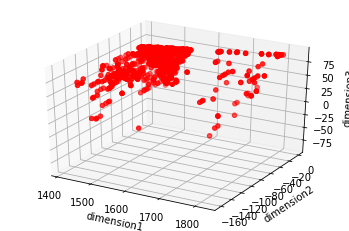

In [26]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(x,y,z, c='r', marker='o')

ax.set_xlabel('dimension1')
ax.set_ylabel('dimension2')
ax.set_zlabel('dimension3')

plt.show()

Congratulations, we are done! We can see two clusters in the data set. We can also see a third cluster which either can be outliers or a real cluster. In the next course we will actually learn how to compute clusters automatically. For now we know that the data indicates that there are two semi-stable states of the machine and sometime we see some anomalies since those data points don't fit into one of the two clusters.